In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
import numpy as np

In [2]:
data_dir = './data/cifar10'

In [3]:
print(os.listdir(data_dir))

['test', 'train']


In [4]:
classes = os.listdir(data_dir + "/train")
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
print(len(classes))

10


Normalize the image tensors by subtrating the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affectiong the losses and gradients while training, simply by having higher or wider range of values then others

We will apply randomly chosen transformation while loading images from the training dataset. Specifically, we will pad each image by 4 image. And we will also, flip the image horizontally with a 50% probability.

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [7]:
# Data transforms (Normalization & data Augmentation)
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [8]:
# Pytorch Dataset
train_ds = ImageFolder(data_dir+'/train',train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms)

In [9]:
from torch.utils.data import DataLoader

In [10]:
batch_size = 256
torch.cuda.is_available()

True

In [11]:
# Pytorch dataLoaders

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=4)

In [13]:
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False,num_workers=4)

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:100],10).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


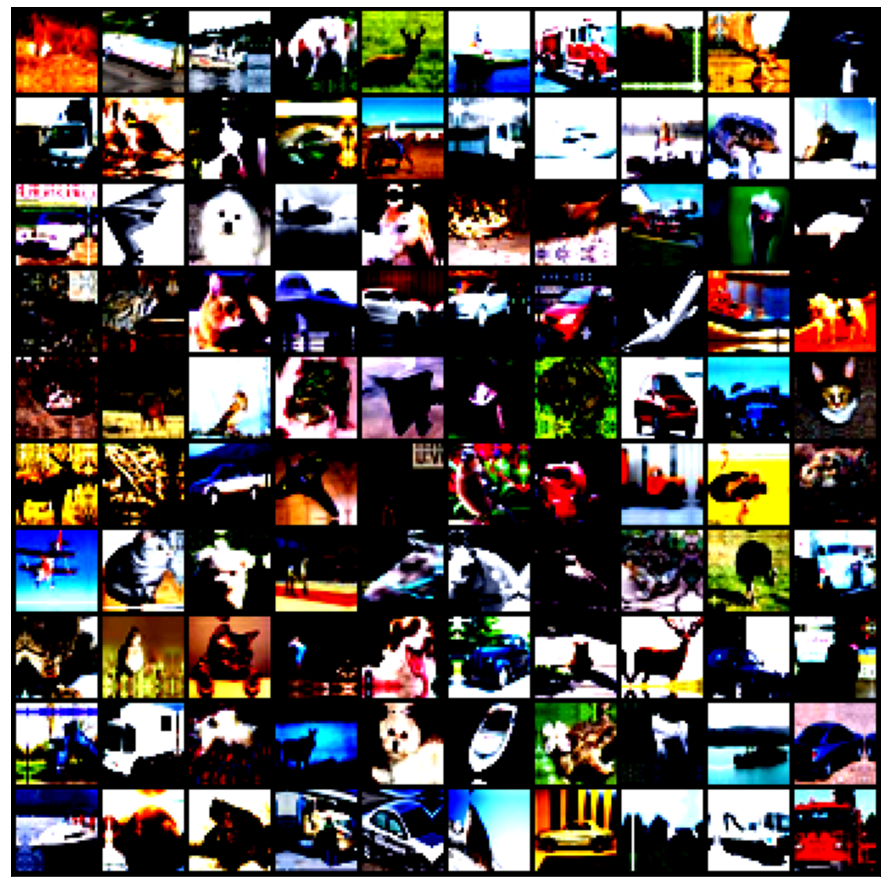

In [16]:
show_batch(train_dl)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
    
    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out)+x

In [19]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])


In [20]:
# ni=inputchannel,nf=outputchannel,ks=kernelsize
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(
        in_channels=ni,
        out_channels=nf,
        kernel_size=ks,
        stride=stride,
        padding=ks//2,
        bias=False
    )

def bn_relu_conv(ni,nf):
    return nn.Sequential(
        nn.BatchNorm2d(ni),
        nn.ReLU(inplace=True),
        conv_2d(ni,nf)
    )

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self,ni,nf,stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni,nf,stride)
        self.conv2 = bn_relu_conv(nf,nf)
        self.shortcut = lambda x:x
        if ni != nf:
            self.shortcut = conv_2d(ni,nf,stride,1)
            
    def forward(self,x):
        x = F.relu(self.bn(x),inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [22]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf,nf) for j in range(1,N)]
    return [start]+rest

In [23]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.view(x.size(0),-1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes,k=1, n_start=16):
        super().__init__()
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3,n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels and downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i],n_channels[i+1],stride)
            
        # Pool, flatten & add linear layer for classification
        layers += [
            nn.BatchNorm2d(n_channels[3]),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(n_channels[3],n_classes)
        ]
        self.features = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.features(x)
    
def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes=10,k=6)

In [24]:
model = wrn_22()
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [25]:
for images, labels in train_dl:
    print('images.shape: ', images.shape)
    out = model(images)
    print('out.shape: ',out.shape)
    break

images.shape:  torch.Size([256, 3, 32, 32])
out.shape:  torch.Size([256, 10])


In [26]:
def get_default_device():
    '''Pick GPU if available, else CPU'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [27]:
device = get_default_device()
device

device(type='cuda')

In [35]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device,non_blocking=True)

In [28]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        '''Yield a batch of data after moving it to device'''
        for b in self.dl:
            yield to_device(b, self.device) # Yield return things one by one
    def __len__(self):
        '''Number of batches'''
        return len(self.dl)

In [36]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)
to_device(model,device)

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    if opt is not None: # we use this for validation also, when opt is None
        # Compute gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds,yb)
        
    return loss.item(), len(xb), metric_result

In [38]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
                  for xb,yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses,nums)) / total
        avg_metric = None
        if metric is not None:
            # Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics,nums)) / total
    return avg_loss, total, avg_metric

In [40]:
def fit(epochs, model, loss_fn, train_dl, valid_dl,opt_fn=None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [],[],[]
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr = lr)
    
    for epoch in range(epochs):
        # Training
        model.train() # indicate that we are in training mode
        for xb, yb in train_dl:
            train_loss,_,_ = loss_batch(model,loss_fn,xb,yb,opt)
        
        # Evaluation
        model.eval() # indicate that we are in eval mode
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        # Print Progress
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'
                  .format(epoch+1,epochs,train_loss,val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val{}: {:.4f}'
                  .format(epoch+1,epochs,train_loss,val_loss,metric.__name__,val_metric))
    return train_losses, val_losses, val_metrics

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [43]:
val_loss, _ , val_acc = evaluate(model,F.cross_entropy,valid_dl,metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss,val_acc))

Loss: 2.3368, Accuracy: 0.0984


In [47]:
nums_epochs = 20
opt_fn = torch.optim.Adam
lr = 0.005

In [46]:
history = fit(nums_epochs,model,F.cross_entropy,train_dl,valid_dl,opt_fn,lr,accuracy)
train_losses, val_losses, val_metrics = history

Epoch [1/10], train_loss: 1.2790, val_loss: 1.3238, valaccuracy: 0.5413
Epoch [2/10], train_loss: 0.7340, val_loss: 1.1087, valaccuracy: 0.6154
Epoch [3/10], train_loss: 0.8462, val_loss: 0.7906, valaccuracy: 0.7285
Epoch [4/10], train_loss: 0.6922, val_loss: 0.8826, valaccuracy: 0.6983
Epoch [5/10], train_loss: 0.6356, val_loss: 0.5941, valaccuracy: 0.7997
Epoch [6/10], train_loss: 0.5772, val_loss: 0.5993, valaccuracy: 0.7992
Epoch [7/10], train_loss: 0.3447, val_loss: 0.5412, valaccuracy: 0.8201
Epoch [8/10], train_loss: 0.2944, val_loss: 0.5543, valaccuracy: 0.8218
Epoch [9/10], train_loss: 0.3510, val_loss: 0.4320, valaccuracy: 0.8532
Epoch [10/10], train_loss: 0.3099, val_loss: 0.4053, valaccuracy: 0.8649


In [48]:
history2 = fit(nums_epochs,model,F.cross_entropy,train_dl,valid_dl,opt_fn,lr,accuracy)
train_losses2, val_losses2, val_metrics2 = history2

Epoch [1/20], train_loss: 0.2069, val_loss: 0.4191, valaccuracy: 0.8629
Epoch [2/20], train_loss: 0.4395, val_loss: 0.4904, valaccuracy: 0.8478
Epoch [3/20], train_loss: 0.2544, val_loss: 0.4228, valaccuracy: 0.8718
Epoch [4/20], train_loss: 0.2909, val_loss: 0.3843, valaccuracy: 0.8731
Epoch [5/20], train_loss: 0.3195, val_loss: 0.4103, valaccuracy: 0.8722
Epoch [6/20], train_loss: 0.2517, val_loss: 0.3505, valaccuracy: 0.8918
Epoch [7/20], train_loss: 0.1593, val_loss: 0.3495, valaccuracy: 0.8927
Epoch [8/20], train_loss: 0.1174, val_loss: 0.4571, valaccuracy: 0.8692
Epoch [9/20], train_loss: 0.1255, val_loss: 0.3627, valaccuracy: 0.8942
Epoch [10/20], train_loss: 0.3080, val_loss: 0.3748, valaccuracy: 0.8893
Epoch [11/20], train_loss: 0.1951, val_loss: 0.3227, valaccuracy: 0.9056
Epoch [12/20], train_loss: 0.1834, val_loss: 0.3341, valaccuracy: 0.9029
Epoch [13/20], train_loss: 0.2330, val_loss: 0.3532, valaccuracy: 0.9058
Epoch [14/20], train_loss: 0.2460, val_loss: 0.3841, valaccu